In [94]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [95]:
#basic RNN
import tensorflow as tf

n_inputs =3
n_neurons = 5

X0 =  tf.placeholder(tf.float32, [None, n_inputs])
X1 = tf.placeholder(tf.float32, [None, n_inputs])

Wx = tf.Variable(tf.random_normal(shape=[n_inputs, n_neurons], dtype=tf.float32))
Wy = tf.Variable(tf.random_normal(shape=[n_neurons, n_neurons], dtype=tf.float32))
b = tf.Variable(tf.zeros([1, n_neurons], dtype=tf.float32))

Y0 = tf.tanh(tf.matmul(X0, Wx) +b)
Y1 = tf.tanh(tf.matmul(Y0, Wy) + tf.matmul(X1, Wx) + b)

init = tf.global_variables_initializer()

In [96]:
import numpy as np

X0_batch = np.array([[0,1,2], [3,4,5], [6,7,8], [9,0,1]])
X1_batch = np.array([[9,8,7],[0,0,0],[6,5,4],[3,2,1]])

with tf.Session() as sess:
    init.run()
    Y0_val, Y1_val = sess.run([Y0, Y1], feed_dict={X0:X0_batch, X1:X1_batch})
    

In [97]:
print(Y0_val)

[[-0.96887857  0.99492675 -0.87908506 -0.81674796  0.86884105]
 [-0.99999684  1.         -0.8769342  -0.85991526 -0.95082754]
 [-1.          1.         -0.8747476  -0.89351    -0.99991083]
 [-0.999959    1.          1.          0.9999977  -1.        ]]


In [98]:
print(Y1_val)

[[-0.9999995   1.         -0.06750162  0.23787697 -1.        ]
 [ 0.9702238  -0.9997855  -0.9323646  -0.95568305 -0.23692536]
 [-0.9999222   1.         -0.33531412 -0.7951014  -0.99999976]
 [-0.9999263   0.9109921   0.97845733 -0.9934738  -0.99875754]]


## BasicRNNCell

In [99]:
tf.reset_default_graph()
# static unrolling through time

X0 = tf.placeholder(tf.float32, [None, n_inputs])
X1 = tf.placeholder(tf.float32, [None, n_inputs])
# we create input palceholders

basic_cell = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)
#  we create BasicRNNCell which you can think of as a factory that creates copies of the cell to build the unrolled RNN

output_seqs,states = tf.contrib.rnn.static_rnn(
                     basic_cell, [X0, X1], dtype=tf.float32)
# we call static rnn which calls the BasicRNNCell creating two copies of cell


Y0, Y1 = output_seqs

In [100]:
# if there wer 50 time steps, it wouldnot be ery convenient to have ot 
# define 50 input placeholders and 50 output tensors

print(Y0)
print(Y1)



Tensor("rnn/basic_rnn_cell/Tanh:0", shape=(?, 5), dtype=float32)
Tensor("rnn/basic_rnn_cell/Tanh_1:0", shape=(?, 5), dtype=float32)


In [101]:
# using the packing sequences
init = tf.global_variables_initializer()

with tf.Session() as sess:
    init.run()
    Y0_val, Y1_val = sess.run([Y0, Y1], feed_dict={X0:X0_batch, X1:X1_batch})

In [102]:
Y0_val

array([[-0.33344507, -0.8871938 ,  0.76357126, -0.8091733 , -0.3623671 ],
       [-0.87720096, -0.9963409 ,  0.63229465, -0.999676  , -0.94258803],
       [-0.983024  , -0.9998876 ,  0.45082512, -0.9999995 , -0.9962745 ],
       [ 0.2274    ,  0.9784933 , -0.9999456 , -0.9999882 , -0.9086115 ]],
      dtype=float32)

In [103]:
Y1_val

array([[-0.9984469 , -0.999849  , -0.78598344, -0.99999994, -0.9993153 ],
       [-0.81159896, -0.781047  ,  0.74046755,  0.14274643, -0.01107246],
       [-0.9916415 , -0.9953612 , -0.48467255, -0.9999374 , -0.9809108 ],
       [-0.4498878 , -0.07954597, -0.9649038 , -0.77888614, -0.3589673 ]],
      dtype=float32)

In [104]:
# from tensorflow_graph_in_jupyter import show_graph

# show_graph(tf.get_default_graph())

## Packing Sequences

In [105]:
# the following cide builds the same RNN again but thistime it takes asingle input 
# placeholder of hsape [None, n_steps, n_inputs ] where the first  fimensions is the mini batch size\
# Then it extract thelist of input sequences for each time step
# X_seqs is a Python list of n_steps tensors of shape [None,n_inputs]
# where once again the first dimension is the mini batch size
# To do this, we first swap using transpose function so that the time steps are now the first dimension 
# then we use the unstack function. The next twolines are the sam
# finally we merge the the output tensors into a single tensor using stack() function
# and we sqap the first two fimension to get a final outputs tensor
# of shape [None, n_steps, n_neurons]

n_steps =2
tf.reset_default_graph()

X = tf.placeholder(tf.float32, [None, n_steps,n_inputs])
X_seqs = tf.unstack(tf.transpose(X,perm=[1,0,2]))
basic_cell = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)
output_seqs, states = tf.contrib.rnn.static_rnn(basic_cell, X_seqs, dtype=tf.float32)
outputs = tf.transpose(tf.stack(output_seqs), perm=[1,0,2])

In [106]:
init = tf.global_variables_initializer()

In [107]:
X_batch= np.array([
    [[0,1,2], [9,8,7]],
    [[3,4,5], [0,0,0]],
    [[6,7,8], [6,5,4]],
    [[9,0,1], [3,2,1]]
])
g = tf.Graph()
with tf.Session() as sess:
    init.run()
    outputs_val = outputs.eval(feed_dict={X:X_batch})

# this stillgets one graph containing unit cell per time step
# If there were 50 time steps the graph would look pretty ugly
print(outputs_val)

# with large graph we will also get out of memory errors so that it can
# use them to compute gradients during the reverse pass
# thats why we using dynamic rnn

[[[ 0.04119638 -0.3549417  -0.1397426   0.8115597  -0.92629695]
  [-0.9997577  -0.95864826 -0.90297073  0.99999887 -0.9999999 ]]

 [[-0.8654581  -0.8533698  -0.5744203   0.99943614 -0.9998663 ]
  [-0.8124397  -0.26177883  0.47357374 -0.7571716  -0.81069404]]

 [[-0.9904655  -0.9740462  -0.82347786  0.99999845 -0.99999976]
  [-0.99934167 -0.9477981  -0.16875382  0.9984857  -0.99998355]]

 [[-0.99996185  0.8240275   0.87919     0.7555452  -0.29852155]
  [-0.95295006 -0.46174273 -0.6823906   0.9925794  -0.9897191 ]]]


In [108]:
print(np.transpose(outputs_val, axes=[1,0,2])[1])

[[-0.9997577  -0.95864826 -0.90297073  0.99999887 -0.9999999 ]
 [-0.8124397  -0.26177883  0.47357374 -0.7571716  -0.81069404]
 [-0.99934167 -0.9477981  -0.16875382  0.9984857  -0.99998355]
 [-0.95295006 -0.46174273 -0.6823906   0.9925794  -0.9897191 ]]


In [109]:
import tensorflow as tf
tf.reset_default_graph()

n_steps =2
n_inputs = 3
n_neurons = 5

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])

basic_cell = tf.nn.rnn_cell.BasicRNNCell(num_units=n_neurons)
outputs, states = tf.nn.dynamic_rnn(basic_cell, X, dtype=tf.float32)

In [110]:
init = tf.global_variables_initializer()

In [111]:
import numpy as np
X_batch =  np.array([
    [[0,1,2], [9,8,7]],
    [[3,4,5], [0,0,0]],
    [[6,7,8], [6,5,4]],
    [[9,0,1], [3,2,1]]
])

with tf.Session() as sess:
    init.run()
    outputs_val = outputs.eval(feed_dict={X:X_batch})

In [112]:
print(outputs_val)

# show_graph(tf.get_default_graph())

[[[ 0.0623136   0.60720366  0.29671496 -0.46884027 -0.4579005 ]
  [-0.99146926  0.9999989  -0.9926949  -0.99282956  0.5767534 ]]

 [[-0.70163757  0.9979865  -0.4373266  -0.9239755  -0.37308863]
  [ 0.7175719  -0.8878805  -0.06190734 -0.08258605 -0.8685115 ]]

 [[-0.94716024  0.9999917  -0.846523   -0.9914016  -0.281547  ]
  [-0.64263844  0.99545556 -0.9443589  -0.9506459  -0.77511656]]

 [[-0.9999411   0.99858433 -0.99968034 -0.77025354 -0.05470882]
  [ 0.07814594  0.23871504 -0.71934676 -0.6922187  -0.84680873]]]


## Setting the sequence lengths

In [113]:
n_steps = 2
n_inputs = 3
n_neurons = 5

tf.reset_default_graph()

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
basic_cell = tf.nn.rnn_cell.BasicRNNCell(num_units=n_neurons)


In [114]:
seq_length = tf.placeholder(tf.int32, [None])
outputs, states = tf.nn.dynamic_rnn(basic_cell, X, dtype=tf.float32,
                                    sequence_length=seq_length)

In [115]:
init = tf.global_variables_initializer()

In [116]:
X_batch = np.array([
    #step 0   step 1
    [[0,1,2], [9,8,7]], # instance 1
    [[3,4,5], [0,0,0]], # Padded Instance 2
    [[6,7,8], [6,5,4]], # instance 3
    [[9,0,1], [3,2,1]],  # instance 4
])

seq_length_batch = np.array([2,1,2,2])

In [117]:
with tf.Session() as sess:
    init.run()
    outputs_val, states_val = sess.run(
        [outputs, states],feed_dict={X:X_batch, seq_length: seq_length_batch })
    

In [118]:
print(outputs_val)

[[[-0.8523153   0.41135153  0.5730545   0.47842172  0.70378107]
  [-0.72656137 -0.9987664   0.9999504   0.9999982   0.613883  ]]

 [[-0.95907134 -0.5810762   0.9930807   0.9919761   0.8945122 ]
  [ 0.          0.          0.          0.          0.        ]]

 [[-0.9891109  -0.943104    0.9999112   0.99990803  0.96496   ]
  [ 0.30286774 -0.996347    0.9982821   0.9999812  -0.46946025]]

 [[ 0.9886445  -0.9999267   0.9998004   0.9999764  -0.95163345]
  [ 0.98093736 -0.9868048   0.9981864   0.8564184   0.3266292 ]]]


In [119]:
print(states_val)

[[-0.72656137 -0.9987664   0.9999504   0.9999982   0.613883  ]
 [-0.95907134 -0.5810762   0.9930807   0.9919761   0.8945122 ]
 [ 0.30286774 -0.996347    0.9982821   0.9999812  -0.46946025]
 [ 0.98093736 -0.9868048   0.9981864   0.8564184   0.3266292 ]]


## Training a sequence classifier

In [120]:
tf.reset_default_graph()

n_steps =28
n_inputs = 28
n_neurons = 150
n_outputs = 10

learning_rate = 0.001

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.int32, [None])

# these are the two lines that are defining a RNN
basic_cell = tf.nn.rnn_cell.BasicRNNCell(num_units=n_neurons)
outputs, states = tf.nn.dynamic_rnn(basic_cell, X # from feed_dict
                                    ,dtype=tf.float32)

# dynamic and static rnn bothe functions calls the BasicRNNCell call function per input
# createing two copise with n_neurons no. of connection between the layers
# it returns twoobjects  python list containing the output tensors foreach step and final states of the network
#in basic cell the final state is equal to the last output

logits = tf.layers.dense(states, n_outputs)
xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y  # from feed_dict
                                                          , logits=logits)

loss= tf.reduce_mean(xentropy)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)

training_op = optimizer.minimize(loss)
correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()

In [121]:
(X_train,y_train), (X_test,y_test) = tf.keras.datasets.mnist.load_data()
X_train = X_train.astype(np.float32).reshape(-1, 28 * 28)/ 255.0
X_test = X_test.astype(np.float32).reshape(-1, 28 * 28)/255.0
y_train = y_train.astype(np.int32)
y_test = y_test.astype(np.int32)

X_valid, X_train = X_train[:5000], X_train[5000:]
y_valid, y_train = y_train[:5000], y_train[5000:]


In [122]:
def shuffle_batch(X, y, batch_size):
    rnd_idx = np.random.permutation(len(X))
    n_batches = len(X) // batch_size
    for batch_idx in np.array_split(rnd_idx, n_batches):
        X_batch, y_batch = X[batch_idx], y[batch_idx]
        yield X_batch, y_batch
        # this is a generator
        # multiple returns to single call

In [123]:
X_test = X_test.reshape((-1, n_steps,n_inputs))

In [124]:
n_epochs = 100
batch_size = 150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            X_batch = X_batch.reshape((-1, n_steps,n_inputs ))
            sess.run(training_op,feed_dict={X:X_batch,y: y_batch})
        acc_batch = accuracy.eval(feed_dict={X:X_batch, y:y_batch})
        acc_test = accuracy.eval(feed_dict={X:X_test, y:y_test})
        print(epoch,"Last batch accuracy: ", acc_batch, "Test accuracy:", acc_test)

0 Last batch accuracy:  0.92 Test accuracy: 0.922
1 Last batch accuracy:  0.96 Test accuracy: 0.9493
2 Last batch accuracy:  0.9533333 Test accuracy: 0.9553
3 Last batch accuracy:  0.9533333 Test accuracy: 0.9621
4 Last batch accuracy:  0.9866667 Test accuracy: 0.9651
5 Last batch accuracy:  0.9533333 Test accuracy: 0.9499
6 Last batch accuracy:  0.97333336 Test accuracy: 0.9643
7 Last batch accuracy:  0.9866667 Test accuracy: 0.9712
8 Last batch accuracy:  0.96666664 Test accuracy: 0.9718
9 Last batch accuracy:  0.9866667 Test accuracy: 0.9706
10 Last batch accuracy:  0.9866667 Test accuracy: 0.9733
11 Last batch accuracy:  0.98 Test accuracy: 0.9756
12 Last batch accuracy:  0.9866667 Test accuracy: 0.9699
13 Last batch accuracy:  0.9866667 Test accuracy: 0.977
14 Last batch accuracy:  0.96666664 Test accuracy: 0.9725
15 Last batch accuracy:  0.9866667 Test accuracy: 0.9732
16 Last batch accuracy:  0.99333334 Test accuracy: 0.976
17 Last batch accuracy:  0.98 Test accuracy: 0.9637
18 

### Multi Layer RNN

In [125]:
# multi layer RNN

tf.reset_default_graph()

n_steps = 28
n_inputs = 28
n_outputs = 10

learning_rate = 0.001

X = tf.placeholder(tf.float32, [None,n_steps, n_inputs])
y = tf.placeholder(tf.int32, [None])

In [126]:
n_neurons = 100
n_layers = 2

layers = [tf.nn.rnn_cell.BasicRNNCell(num_units=n_neurons, activation=tf.nn.relu)for layer in range(n_layers)]
# layers is not required here

multi_layer_cell = tf.nn.rnn_cell.MultiRNNCell(layers)
outputs, states = tf.nn.dynamic_rnn(multi_layer_cell, X, dtype=tf.float32)

In [127]:
states_concat = tf.concat(axis=1, values=states)

logits = tf.layers.dense(states_concat,n_outputs)
xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
loss = tf.reduce_mean(xentropy)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()

In [128]:
n_epochs = 10
batch_size = 150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            X_batch = X_batch.reshape((-1,n_steps,n_inputs ))
            sess.run(training_op, feed_dict={X:X_batch, y:y_batch})
        acc_batch = accuracy.eval(feed_dict={X:X_batch, y: y_batch})
        acc_test = accuracy.eval(feed_dict={X:X_test, y: y_test})
        print(epoch, "last batch accuracy: ", acc_batch, "test_accuracy: ", acc_test)

0 last batch accuracy:  0.9533333 test_accuracy:  0.9096
1 last batch accuracy:  0.96666664 test_accuracy:  0.957
2 last batch accuracy:  0.98 test_accuracy:  0.9701
3 last batch accuracy:  0.99333334 test_accuracy:  0.9699
4 last batch accuracy:  0.9866667 test_accuracy:  0.9735
5 last batch accuracy:  0.9866667 test_accuracy:  0.9774
6 last batch accuracy:  0.96666664 test_accuracy:  0.9807
7 last batch accuracy:  0.99333334 test_accuracy:  0.9779
8 last batch accuracy:  0.9866667 test_accuracy:  0.9812
9 last batch accuracy:  0.9866667 test_accuracy:  0.9791


### Predicting time series

In [129]:
# creating a RNN ,of 100recurrent neurons 
# we willunrollover 20 time steps since
# the traininginstance will be 20 inputs long
# each input will contain only one feature (the value at that time)
# the targets are also seuquences of 20 inputs each containing a single value

t_min, t_max = 0,30
resolution = 0.1

def time_series(t):
    return t * np.sin(t) / 3 * 2 * np.sin(t*5)

def next_batch(batch_size, n_steps):
    t0 = np.random.rand(batch_size,1) * (t_max - t_min - n_steps * resolution)
    # print("to: ",t0)
    Ts = t0 + np.arange(0., n_steps + 1) * resolution
    # print("ts: ",Ts)
    ys = time_series(Ts)
    # print("ys: ",ys)
    return ys[:,:-1].reshape(-1, n_steps, 1), ys[:, 1:].reshape(-1, n_steps, 1)

In [130]:
print(time_series(1))

-0.537937969171326


In [131]:
print(next_batch(1, 5))

(array([[[-2.27045862],
        [ 1.88106638],
        [ 4.47743074],
        [ 5.05600633],
        [ 3.93721214]]]), array([[[1.88106638],
        [4.47743074],
        [5.05600633],
        [3.93721214],
        [2.03397945]]]))



 [12.2   12.305 12.41  12.515 12.62  12.725 12.83  12.935 13.04  13.145
 13.25  13.355 13.46  13.565 13.67  13.775 13.88  13.985 14.09  14.195
 14.3  ]


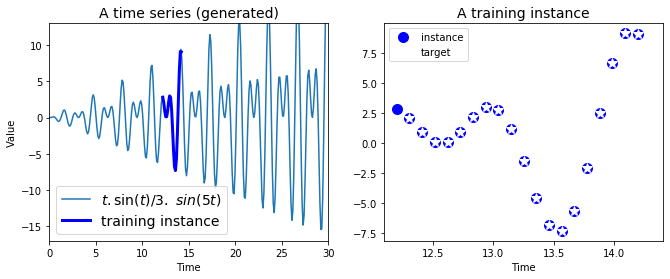

In [132]:
import matplotlib.pyplot as plt
import numpy as np

t = np.linspace(t_min, t_max,int((t_max - t_min)/resolution))
#print(t)

n_steps = 20
t_instance = np.linspace(12.2, 12.2 + resolution * (n_steps + 1), n_steps + 1 )
print("\n", t_instance)

plt.figure(figsize=(11, 4))
plt.subplot(121)
plt.title("A time series (generated)", fontsize=14)
plt.plot(t,time_series(t), label=r"$t . \sin(t) / 3 . \ sin(5t)$")
plt.plot(t_instance[:-1],time_series(t_instance[:-1]), "b-", linewidth=3,label="training instance")
plt.legend(loc="lower left", fontsize=14)
plt.axis([0, 30, -17, 13])
plt.xlabel("Time")
plt.ylabel("Value")

plt.subplot(122)
plt.title("A training instance", fontsize=14)
plt.plot(t_instance[:-1], time_series(t_instance[:-1]), "bo", markersize=10, label="instance")
plt.plot(t_instance[1:], time_series(t_instance[1:]), "w*", markersize=10,label="target")
plt.legend(loc="upper left")
plt.xlabel("Time")

plt.show()

In [133]:
X_batch, y_batch =next_batch(1, n_steps)

In [134]:
np.c_[X_batch[0], y_batch[0]]

array([[ 0.34962656,  0.02691639],
       [ 0.02691639,  0.08498895],
       [ 0.08498895,  0.51277104],
       [ 0.51277104,  1.10302784],
       [ 1.10302784,  1.52880554],
       [ 1.52880554,  1.47421005],
       [ 1.47421005,  0.77184764],
       [ 0.77184764, -0.50572284],
       [-0.50572284, -2.03888299],
       [-2.03888299, -3.3474306 ],
       [-3.3474306 , -3.94592018],
       [-3.94592018, -3.51648009],
       [-3.51648009, -2.03828124],
       [-2.03828124,  0.17524455],
       [ 0.17524455,  2.55043351],
       [ 2.55043351,  4.4196953 ],
       [ 4.4196953 ,  5.22822985],
       [ 5.22822985,  4.71324309],
       [ 4.71324309,  2.99473614],
       [ 2.99473614,  0.54521412]])

In [135]:
# using an OutputProjectionWrapper
import tensorflow as tf
tf.reset_default_graph()

n_steps= 20
# what are steps 

n_inputs = 1
n_neurons = 100
# what are neurons

n_outputs = 1

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32,[None,n_steps,n_outputs])

cell = tf.nn.rnn_cell.BasicRNNCell(num_units=n_neurons, activation=tf.nn.relu)
outputs, states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)


In [136]:
# howeverwhat we want is a signle output value at each step
# right now we have 100 output vectors
# in the code above

tf.reset_default_graph()

n_steps = 20
n_inputs = 1
n_neurons = 100
n_outputs = 1

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs ])
y = tf.placeholder(tf.float32, [None, n_steps, n_outputs])


In [137]:
cell = tf.contrib.rnn.OutputProjectionWrapper(
tf.nn.rnn_cell.BasicRNNCell(num_units=n_neurons, activation=tf.nn.relu),output_size=n_outputs)

In [138]:
outputs, states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)

In [139]:
learning_rate = 0.001

loss = tf.reduce_mean(tf.square(outputs - y))
optimizer = tf.train.AdamOptimizer(learning_rate= learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()

In [140]:
saver = tf.train.Saver()

In [142]:
n_iterations = 1500
batch_size = 50

with tf.Session() as sess:
    init.run()
    for iteration in range(n_iterations):
        X_batch, y_batch = next_batch(batch_size,n_steps )
        sess.run(training_op, feed_dict={X:X_batch,y:y_batch})
        if iteration % 100 == 0:
            mse = loss.eval(feed_dict={X: X_batch, y:y_batch})
            print(iteration, "\tMSE:", mse)
        saver.save(sess, "./my_time_series_model_new")

0 	MSE: 21.761175
100 	MSE: 1.3441672
200 	MSE: 0.42804807
300 	MSE: 0.78710335
400 	MSE: 0.49974084
500 	MSE: 0.45366803
600 	MSE: 0.28945673
700 	MSE: 0.40049306
800 	MSE: 0.31824774
900 	MSE: 0.35676542
1000 	MSE: 0.39028546
1100 	MSE: 0.2513819
1200 	MSE: 0.44661164
1300 	MSE: 0.5128407
1400 	MSE: 0.23056522


In [143]:
with tf.Session() as sess:
    saver.restore(sess, "./my_time_series_model_new")
    
    X_new = time_series(np.array(t_instance[:-1].reshape(-1, n_steps, n_inputs)))
    y_pred = sess.run(outputs, feed_dict={X: X_new})

In [144]:
y_pred

array([[[ 2.59446   ],
        [ 0.6136053 ],
        [-0.42247868],
        [-0.31221056],
        [ 0.8716989 ],
        [ 2.2447693 ],
        [ 3.0500097 ],
        [ 2.908892  ],
        [ 1.3505651 ],
        [-1.4555708 ],
        [-4.6396046 ],
        [-6.9470587 ],
        [-7.465141  ],
        [-5.789268  ],
        [-2.118606  ],
        [ 2.6241388 ],
        [ 6.842867  ],
        [ 9.222857  ],
        [ 9.165384  ],
        [ 6.552421  ]]], dtype=float32)

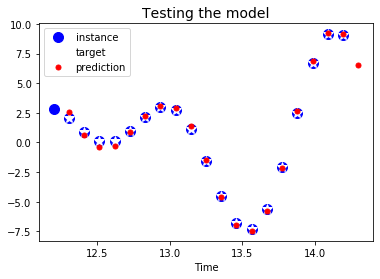

In [145]:
plt.title("Testing the model", fontsize =14)
plt.plot(t_instance[:-1], time_series(t_instance[:-1]), "bo", markersize=10, label="instance")
plt.plot(t_instance[1:], time_series(t_instance[1:]), "w*", markersize=10, label="target")
plt.plot(t_instance[1:], y_pred[0, :, 0], "r.", markersize=10, label="prediction")
plt.legend(loc="upper left")
plt.xlabel("Time")

plt.show()

### without using outputprojectionwrapper

In [146]:
tf.reset_default_graph()
tf.set_random_seed(42)
np.random.seed(42)

n_steps = 20
n_inputs = 1
n_neurons = 100
n_outputs = 1

X = tf.placeholder(tf.float32, [None, n_steps,n_inputs])
y = tf.placeholder(tf.float32, [None,n_steps,n_outputs])


In [147]:
cell = tf.nn.rnn_cell.BasicRNNCell(num_units=n_neurons,activation=tf.nn.relu)
rnn_outputs, states = tf.nn.dynamic_rnn(cell,X,dtype=tf.float32)

In [148]:
n_outputs = 1
learning_rate = 0.001

In [149]:
# here we are using a dense laer to give us a single output

stacked_rnn_outputs = tf.reshape(rnn_outputs, [-1,n_neurons ])
stacked_outputs = tf.layers.dense(stacked_rnn_outputs, n_outputs)
outputs = tf.reshape(stacked_outputs, [-1, n_steps,n_outputs])

In [150]:
loss = tf.reduce_mean(tf.square(outputs-y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [151]:
n_iteration = 1500
batch_size = 50

with tf.Session() as sess:
    init.run()
    for iteration in range(n_iterations):
        X_batch, y_batch = next_batch(batch_size,n_steps )
        sess.run(training_op, feed_dict={X:X_batch, y:y_batch})
        if (iteration % 100 == 0):
            mse = loss.eval(feed_dict={X:X_batch, y: y_batch})
            print(iteration, "\tMSE:", mse)
        
    X_new = time_series(np.array(t_instance[:-1].reshape(-1, n_steps, n_inputs)))
    y_pred = sess.run(outputs, feed_dict={X:X_new})
    
    saver.save(sess, "./my_time_series_model_new")
    

0 	MSE: 25.066492
100 	MSE: 1.6778558
200 	MSE: 0.6082689
300 	MSE: 0.62341124
400 	MSE: 0.35037437
500 	MSE: 0.5121326
600 	MSE: 0.44027463
700 	MSE: 0.5210428
800 	MSE: 0.5277624
900 	MSE: 0.43130496
1000 	MSE: 0.37248772
1100 	MSE: 0.3643724
1200 	MSE: 0.38959044
1300 	MSE: 0.45110476
1400 	MSE: 0.3658804


In [152]:
y_pred

array([[[ 2.6722147 ],
        [ 0.6758617 ],
        [-0.32243362],
        [-0.27014327],
        [ 0.84300965],
        [ 2.121756  ],
        [ 3.0417194 ],
        [ 2.9342813 ],
        [ 1.2636949 ],
        [-1.529304  ],
        [-4.7223625 ],
        [-7.030398  ],
        [-7.429443  ],
        [-5.667864  ],
        [-2.0271788 ],
        [ 2.5309901 ],
        [ 6.7677    ],
        [ 9.3568    ],
        [ 9.136802  ],
        [ 6.4486566 ]]], dtype=float32)

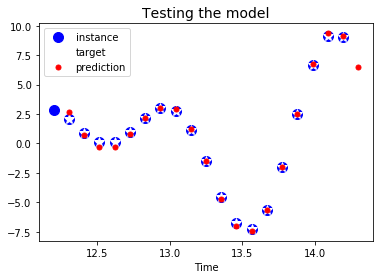

In [153]:
plt.title("Testing the model", fontsize =14)
plt.plot(t_instance[:-1], time_series(t_instance[:-1]), "bo", markersize=10, label="instance")
plt.plot(t_instance[1:], time_series(t_instance[1:]), "w*", markersize=10, label="target")
plt.plot(t_instance[1:],y_pred[0,:,0], "r.", markersize=10, label="prediction")
plt.legend(loc="upper left")
plt.xlabel("Time")

plt.show()

### generating a creative sequence

In [154]:
with tf.Session() as sess:
    saver.restore(sess, "./my_time_series_model_new")
    
    sequence = [0.] * n_steps
    for iteration in range (300):
        X_batch = np.array(sequence[-n_steps:]).reshape(1, n_steps, 1)
        y_pred =sess.run(outputs, feed_dict={X:X_batch})
        sequence.append(y_pred[0,-1,0])

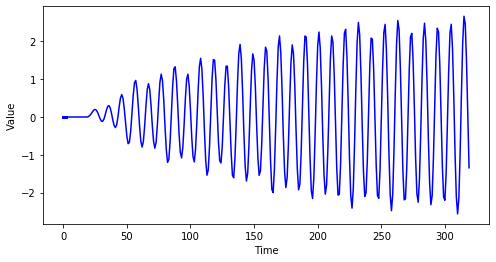

In [155]:
plt.figure(figsize=(8,4))
plt.plot(np.arange(len(sequence)), sequence, "b-")
plt.plot(t[:n_steps], sequence[:n_steps], "b-", linewidth=3)
plt.xlabel("Time")
plt.ylabel("Value")
plt.show()

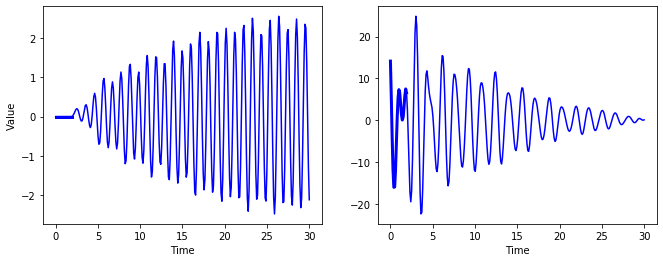

In [156]:
with tf.Session() as sess:
    saver.restore(sess, "./my_time_series_model_new")
    
    sequence1 = [0. for i in range(n_steps)]
    for iteration in range(len(t) - n_steps):
        X_batch = np.array(sequence1[-n_steps:]).reshape(1,n_steps, 1)
        y_pred = sess.run(outputs, feed_dict={X: X_batch })
        sequence1.append(y_pred[0,-1,0])
    sequence2 = [time_series(i * resolution + t_min + (t_max-t_min/3)) for i in range(n_steps)]
    for iteration in range(len(t) - n_steps):
        X_batch =np.array(sequence2[-n_steps:]).reshape(1,n_steps, 1)
        y_pred = sess.run(outputs, feed_dict={X:X_batch})
        sequence2.append(y_pred[0,-1,0])

plt.figure(figsize=(11,4))
plt.subplot(121)
plt.plot(t, sequence1, "b-")
plt.plot(t[:n_steps], sequence1[:n_steps], "b-",linewidth=3 )
plt.xlabel("Time")
plt.ylabel("Value")

plt.subplot(122)
plt.plot(t, sequence2, "b-")
plt.plot(t[:n_steps], sequence2[:n_steps], "b-", linewidth=3)
plt.xlabel("Time")
plt.show()

In [157]:

# with tf.Session() as sess:
#     saver.restore(sess, "./my_time_series_model_new")
    
#     sequence = [0.] * n_steps
#     for iteration in range(300):
#         X_batch = np.array(sequence[-n_steps:]).reshape(1,n_steps,1)
#         y_pred = sess.run(outputs, feed_dict={X:X_batch})

#         sequence.append(y_pred[0,-1, 0])

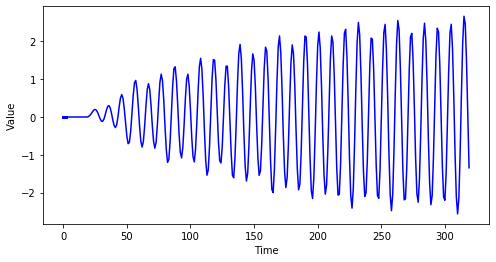

In [158]:
# t_min, t_max = 0, 30
# resolution = 0.1

# t = np.linspace(t_min, t_max, int((t_max - t_min) / resolution))

# plt.figure(figsize=(8,4))
# plt.plot(np.arange(len(sequence)), sequence, "b-")
# plt.plot(t[:n_steps], sequence[:n_steps], "b-", linewidth=3)
# plt.xlabel("Time")
# plt.ylabel("Value")
# plt.show()

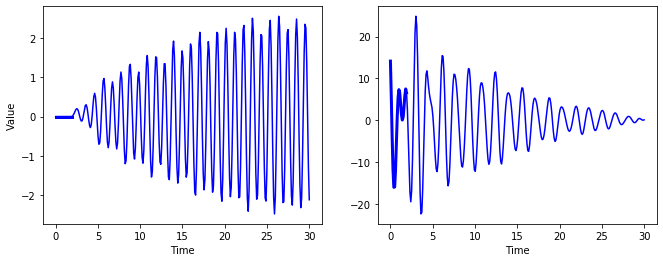

In [159]:
# with tf.Session() as sess:
#     saver.restore(sess, "./my_time_series_model_new")

#     sequence1 = [0. for i in range(n_steps)]
#     for iteration in range(len(t) - n_steps):
#         X_batch = np.array(sequence1[-n_steps:]).reshape(1, n_steps, 1)
#         y_pred = sess.run(outputs, feed_dict={X: X_batch})
#         sequence1.append(y_pred[0, -1, 0])

#     sequence2 = [time_series(i * resolution + t_min + (t_max-t_min/3)) for i in range(n_steps)]
#     for iteration in range(len(t) - n_steps):
#         X_batch = np.array(sequence2[-n_steps:]).reshape(1, n_steps, 1)
#         y_pred = sess.run(outputs, feed_dict={X: X_batch})
#         sequence2.append(y_pred[0, -1, 0])

# plt.figure(figsize=(11,4))
# plt.subplot(121)
# plt.plot(t, sequence1, "b-")
# plt.plot(t[:n_steps], sequence1[:n_steps], "b-", linewidth=3)
# plt.xlabel("Time")
# plt.ylabel("Value")

# plt.subplot(122)
# plt.plot(t, sequence2, "b-")
# plt.plot(t[:n_steps], sequence2[:n_steps], "b-", linewidth=3)
# plt.xlabel("Time")

# plt.show()

### MultiRNNCell

In [160]:
tf.reset_default_graph()

n_inputs = 2
n_steps = 5

X = tf.placeholder(tf.float32, [None,n_steps, n_inputs])


In [161]:
n_neurons = 100
n_layers = 3

layers = [tf.nn.rnn_cell.BasicRNNCell(num_units=n_neurons) for layer in range(n_layers)]

multi_layer_cell = tf.nn.rnn_cell.MultiRNNCell(layers)
outputs, state = tf.nn.dynamic_rnn(multi_layer_cell,X, dtype=tf.float32)


In [162]:
init = tf.global_variables_initializer()

In [163]:
X_batch = np.random.rand(2, n_steps,n_inputs)

In [165]:
# with tf.Session() as sess:
#     init.run()
#     outputs_val, states_val = sess.run([outputs, states], feed_dict={X: X_batch})

In [167]:
#outputs_val.shape

# multi layer rnn has been defined above

### Dropout

In [166]:
tf.reset_default_graph()

n_inputs = 1
n_neurons = 100
n_layers = 3
n_steps = 20
n_outputs = 1

In [168]:
X = tf.placeholder(tf.float32, [None,n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None,n_steps, n_outputs])

In [172]:
keep_prob = tf.placeholder_with_default(1.0, shape=())
# if we togglekeep prob to 0 then there would be no dropout

cells = [tf.nn.rnn_cell.BasicRNNCell(num_units=n_neurons) for layer in range(n_layers)]
cells_drop = [tf.nn.rnn_cell.DropoutWrapper(cell,input_keep_prob=keep_prob ) for cell in cells]

multi_layer_cell = tf.nn.rnn_cell.MultiRNNCell(cells_drop)
rnn_outputs, states = tf.nn.dynamic_rnn(multi_layer_cell, X, dtype=tf.float32)

In [173]:
learning_rate = 0.01

stacked_rnn_outputs = tf.reshape(rnn_outputs, [-1,n_neurons ])
stacked_outputs = tf.layers.dense(stacked_rnn_outputs, n_outputs)
outputs = tf.reshape(stacked_outputs, [-1, n_steps,n_outputs])

loss = tf.reduce_mean(tf.square(outputs - y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [174]:
n_iterations = 1500
batch_size =50
train_keep_prob = 0.5

with tf.Session() as sess:
    init.run()
    for iteration in range(n_iterations):
        X_batch, y_batch = next_batch(batch_size, n_steps)
        _, mse = sess.run([training_op,loss],
                          feed_dict={X:X_batch, y:y_batch,
                                     keep_prob: train_keep_prob})
        if iteration % 100 == 0:
            print(iteration, "Training MSE:", mse)
    
    saver.save(sess, "./my_dropout_time_series_model")

0 Training MSE: 35.582966
100 Training MSE: 8.741092
200 Training MSE: 12.690717
300 Training MSE: 8.558952
400 Training MSE: 8.438201
500 Training MSE: 6.093813
600 Training MSE: 8.873587
700 Training MSE: 9.073093
800 Training MSE: 7.9407773
900 Training MSE: 8.60442
1000 Training MSE: 10.856989
1100 Training MSE: 7.905676
1200 Training MSE: 7.909205
1300 Training MSE: 11.046001
1400 Training MSE: 11.338633


In [176]:
with tf.Session() as sess:
    saver.restore(sess, "my_dropout_time_series_model")
    
    X_new = time_series(np.array(t_instance[:-1]).reshape(-1, n_steps,n_inputs))
    y_pred = sess.run(outputs, feed_dict={X:X_new})

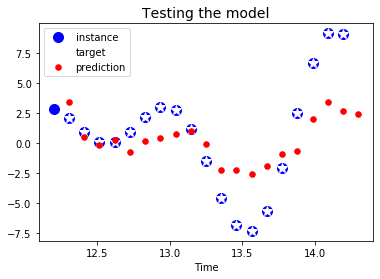

In [178]:
plt.title("Testing the model", fontsize=14)
plt.plot(t_instance[:-1], time_series(t_instance[:-1]), "bo", markersize=10, label="instance")
plt.plot(t_instance[1:],time_series(t_instance[1:]), "w*", markersize=10, label="target")
plt.plot(t_instance[1:], y_pred[0,:,0],"r.", markersize=11,label="prediction")
plt.legend(loc="upper left")
plt.xlabel("Time")

plt.show()

### LSTM

In [179]:
# using an LSTM

tf.reset_default_graph()

lstm_cell = tf.nn.rnn_cell.BasicLSTMCell(num_units=n_neurons)

W0619 07:33:16.745778 14668 deprecation.py:323] From <ipython-input-179-bf2b5e780551>:5: BasicLSTMCell.__init__ (from tensorflow.python.ops.rnn_cell_impl) is deprecated and will be removed in a future version.
Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.


In [181]:
n_steps = 28
n_inputs = 28
n_neurons = 150
n_outputs = 10
n_layers = 3

learning_rate = 0.001

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.int32, [None])

lstm_cells = [tf.nn.rnn_cell.BasicLSTMCell(num_units=n_neurons)
              for layer in range(n_layers)]
multi_cell = tf.nn.rnn_cell.MultiRNNCell(lstm_cells)
outputs, states = tf.nn.dynamic_rnn(multi_cell, X, dtype=tf.float32)
top_layer_h_state = states[-1][1]
logits = tf.layers.dense(top_layer_h_state, n_outputs, name="softmax")
xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
loss = tf.reduce_mean(xentropy, name="loss")
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)
correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
    
init = tf.global_variables_initializer()

In [182]:
states

(LSTMStateTuple(c=<tf.Tensor 'rnn/while/Exit_3:0' shape=(?, 150) dtype=float32>, h=<tf.Tensor 'rnn/while/Exit_4:0' shape=(?, 150) dtype=float32>),
 LSTMStateTuple(c=<tf.Tensor 'rnn/while/Exit_5:0' shape=(?, 150) dtype=float32>, h=<tf.Tensor 'rnn/while/Exit_6:0' shape=(?, 150) dtype=float32>),
 LSTMStateTuple(c=<tf.Tensor 'rnn/while/Exit_7:0' shape=(?, 150) dtype=float32>, h=<tf.Tensor 'rnn/while/Exit_8:0' shape=(?, 150) dtype=float32>))

In [183]:
top_layer_h_state

<tf.Tensor 'rnn/while/Exit_8:0' shape=(?, 150) dtype=float32>

In [185]:
n_epochs = 10
batch_size =150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            X_batch = X_batch.reshape((-1, n_steps, n_inputs ))
            sess.run(training_op, feed_dict={X:X_batch, y:y_batch})
        acc_batch = accuracy.eval(feed_dict={X:X_batch, y:y_batch})
        acc_test = accuracy.eval(feed_dict={X:X_test, y:y_test})
        print(epoch, "last batch acc: ", acc_batch, "test: ", acc_test)

0 last batch acc:  0.94 test:  0.9528
1 last batch acc:  0.94666666 test:  0.9686
2 last batch acc:  0.99333334 test:  0.9778
3 last batch acc:  0.99333334 test:  0.982
4 last batch acc:  0.99333334 test:  0.9834
5 last batch acc:  0.9866667 test:  0.9806
6 last batch acc:  1.0 test:  0.9843
7 last batch acc:  1.0 test:  0.984
8 last batch acc:  0.9866667 test:  0.9882
9 last batch acc:  0.99333334 test:  0.9843


In [186]:
lstm_cell = tf.nn.rnn_cell.LSTMCell(num_units=n_neurons, use_peepholes=True)

W0619 07:48:55.169469 14668 deprecation.py:323] From <ipython-input-186-24b025f4b732>:1: LSTMCell.__init__ (from tensorflow.python.ops.rnn_cell_impl) is deprecated and will be removed in a future version.
Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.


In [187]:
gru_cell = tf.nn.rnn_cell.GRUCell(num_units=n_neurons)

W0619 07:48:55.176451 14668 deprecation.py:323] From <ipython-input-187-4196517ff9aa>:1: GRUCell.__init__ (from tensorflow.python.ops.rnn_cell_impl) is deprecated and will be removed in a future version.
Instructions for updating:
This class is equivalent as tf.keras.layers.GRUCell, and will be replaced by that in Tensorflow 2.0.


## Embeddings

In [1]:
from six.moves import urllib

import errno
import os
import zipfile

WORDS_PATH = "datasets/words"
WORDS_URL = 'http://mattmahoney.net/dc/text8.zip'

def fetch_word_data(words_url = WORDS_URL, words_path=WORDS_PATH):
    os.makedirs(words_path, exist_ok=True)
    zip_path = os.path.join(words_path, "words.zip")
    if not os.path.exists(zip_path):
        urllib.request.urlretrieve(words_url, zip_path)
    with zipfile.ZipFile(zip_path) as f:
        data = f.read(f.namelist()[0])
    return data.decode("ascii").split()


In [2]:
words = fetch_word_data()

In [3]:
words[:5]

['anarchism', 'originated', 'as', 'a', 'term']

### Build the dictionary

In [4]:
from collections import Counter
import numpy as np
vocabulary_size =50000

'''
You should first preprocess the sentence and break it into a list of known words. For
example you may remove unnecessary characters, replace unknown words by a pre‐
defined token word such as “[UNK]”, replace numerical values by “[NUM]”, replace
URLs by “[URL]”, and so on. Once you have a list of known words, you can look up
each word’s integer identifier (from 0 to 49999) in a dictionary, for example [72, 3335,
288].
'''

vocabulary = [("UNK", None)] + Counter(words).most_common(vocabulary_size -1)

vocabulary = np.array([word for word, _ in vocabulary])
dictionary = { word: code for code, word in enumerate(vocabulary)}
data =np.array([dictionary.get(word, 0) for word in words])


In [5]:
" ".join(words[:9]), data[:9]

('anarchism originated as a term of abuse first used',
 array([5234, 3081,   12,    6,  195,    2, 3134,   46,   59]))

In [6]:
" ".join([vocabulary[word_index] for word_index in [5241, 3081, 12, 6, 195, 2, 3134, 46, 59] ])

'cycles originated as a term of abuse first used'

In [7]:
words[24], data[24]

('culottes', 0)

## Generate Batches

In [10]:
from collections import deque

def generate_batch(batch_size, num_skips, skip_window):
    global data_index
    assert batch_size % num_skips == 0 
    # in assert if condition is not met then error is raised
    
    assert num_skips <= 2 * skip_window
    
    batch = np.ndarray(shape=[batch_size], dtype=np.int32)
    labels = np.ndarray(shape=[batch_size, 1], dtype=np.int32)
    span = 2 * skip_window + 1
    buffer = deque(maxlen=span)
    for _ in range(span):
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    for i in range(batch_size // num_skips):
        target = skip_window # target label at center to buffer
        targets_to_avoid = [ skip_window ]
        for j in range(num_skips):
            while target in targets_to_avoid:
                target = np.random.randint(0, span)
            targets_to_avoid.append(target)
            batch[i * num_skips + j] = buffer[skip_window]
            labels[i *num_skips + j] = buffer[target]
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    return batch, labels

# what the heck

In [11]:
np.random.seed(42)

In [12]:
data_index = 0
batch, labels = generate_batch(8,2,1)

In [13]:
batch, [vocabulary[word] for word in batch]

(array([3081, 3081,   12,   12,    6,    6,  195,  195]),
 ['originated', 'originated', 'as', 'as', 'a', 'a', 'term', 'term'])

In [14]:
labels, [vocabulary[word] for word in labels[:, 0]]

(array([[  12],
        [5234],
        [   6],
        [3081],
        [  12],
        [ 195],
        [   2],
        [   6]]),
 ['as', 'anarchism', 'a', 'originated', 'as', 'term', 'of', 'a'])

## Building the model

In [24]:
batch_size = 128
embedding_size = 128  # Dimension of the embedding vector.
skip_window = 1       # How many words to consider left and right.
num_skips = 2         # How many times to reuse an input to generate a label.

# We pick a random validation set to sample nearest neighbors. Here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent.
valid_size = 16     # Random set of words to evaluate similarity on.
valid_window = 100  # Only pick dev samples in the head of the distribution.
valid_examples = np.random.choice(valid_window, valid_size, replace=False)
num_sampled = 64    # Number of negative examples to sample.

learning_rate = 0.01

In [25]:
import tensorflow as tf

tf.reset_default_graph()

#Input data
train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
valid_dataset = tf.constant(valid_examples, dtype=tf.int32)

In [26]:
vocabulary_size =50000
embedding_size = 150

# look up embeddings for inputs

init_embeds = tf.random_uniform([vocabulary_size, embedding_size], -1.0,1.0)
embeddings = tf.Variable(init_embeds)

In [27]:
train_inputs = tf.placeholder(tf.int32, shape=[None])
embed = tf.nn.embedding_lookup(embeddings, train_inputs)

In [28]:
# Construct the variables for the NCE loss
nce_weights = tf.Variable(
    tf.truncated_normal([vocabulary_size, embedding_size],
                        stddev=1.0 / np.sqrt(embedding_size)))
nce_biases = tf.Variable(tf.zeros([vocabulary_size]))

# Compute the average NCE loss for the batch.
# tf.nce_loss automatically draws a new sample of the negative labels each
# time we evaluate the loss.
loss = tf.reduce_mean(
    tf.nn.nce_loss(nce_weights, nce_biases, train_labels, embed,
                   num_sampled, vocabulary_size))

# Construct the Adam optimizer
optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss)

# Compute the cosine similarity between minibatch examples and all embeddings.
norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), axis=1, keepdims=True))
normalized_embeddings = embeddings / norm
valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings, valid_dataset)
similarity = tf.matmul(valid_embeddings, normalized_embeddings, transpose_b=True)

# Add variable initializer.
init = tf.global_variables_initializer()

W0620 11:06:29.708631  1332 deprecation.py:323] From C:\installs\Anaconda\envs\tf_gpu\lib\site-packages\tensorflow_core\python\ops\nn_impl.py:183: where (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


### Train the model

In [31]:
num_steps = 10001

with tf.Session() as session:
    init.run()

    average_loss = 0
    for step in range(num_steps):
        print("\rIteration: {}".format(step), end="\t")
        batch_inputs, batch_labels = generate_batch(batch_size, num_skips, skip_window)
        feed_dict = {train_inputs : batch_inputs, train_labels : batch_labels}

        # We perform one update step by evaluating the training op (including it
        # in the list of returned values for session.run()
        _, loss_val = session.run([training_op, loss], feed_dict=feed_dict)
        average_loss += loss_val

        if step % 2000 == 0:
            if step > 0:
                average_loss /= 2000
            # The average loss is an estimate of the loss over the last 2000 batches.
            print("Average loss at step ", step, ": ", average_loss)
            average_loss = 0

        # Note that this is expensive (~20% slowdown if computed every 500 steps)
        if step % 10000 == 0:
            sim = similarity.eval()
            for i in range(valid_size):
                valid_word = vocabulary[valid_examples[i]]
                top_k = 8 # number of nearest neighbors
                nearest = (-sim[i, :]).argsort()[1:top_k+1]
                log_str = "Nearest to %s:" % valid_word
                for k in range(top_k):
                    close_word = vocabulary[nearest[k]]
                    log_str = "%s %s," % (log_str, close_word)
                print(log_str)

    final_embeddings = normalized_embeddings.eval()

Iteration: 0	Average loss at step  0 :  284.8593444824219
Nearest to are: embroidered, bourdieu, itching, simpsons, denotation, weekend, lusignan, cocoa,
Nearest to first: clusters, homosexual, nazarene, causative, fence, shaftesbury, iquique, tabs,
Nearest to history: cha, imagery, stol, gard, disagrees, undulating, trivia, china,
Nearest to when: clinical, transmembrane, tyres, childish, alternatives, capybara, nasty, pressburg,
Nearest to from: piecewise, malachi, ingredients, yggdrasil, colder, lazarus, appears, linnaean,
Nearest to as: lethe, intersect, tuba, outpost, radek, johore, caterpillars, kristallnacht,
Nearest to th: foothills, atreides, partit, modules, mistaking, span, determinative, explorers,
Nearest to use: laminal, enactment, lieberman, proliferate, dreamworks, matador, bullseye, empties,
Nearest to nine: tides, gelasian, gut, ath, bahraini, bruises, indochina, jupiter,
Nearest to into: porphyry, praline, mycelium, artful, chiropractic, densities, tsvetaeva, lactase

In [32]:
# savin teh embeddings
np.save("./my_final_embeddings.npy", final_embeddings)

## Plotting the embeddings

In [33]:
def plot_with_labels(low_dim_embs,labels):
    assert low_dim_embs.shape[0] <= len(labels),"More labels than embeddings"
    plt.figure(figsize=(18, 18)) # in inches
    for i, label in enumerate (labels):
        x, y = low_dim_embs[i, :]
        plt.scatter(x,y)
        plt.annotate(label,
                     xy=(x, y),
                     xytest=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
        

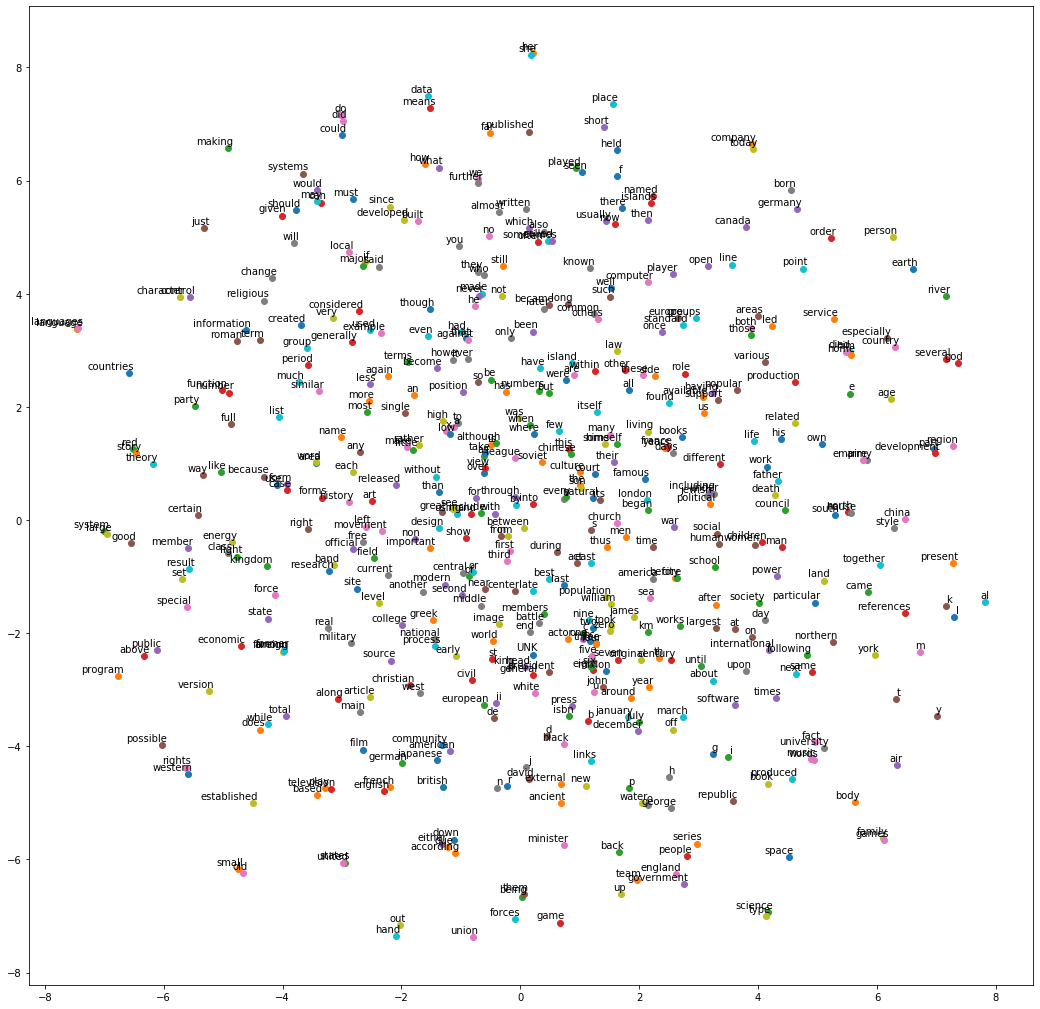

In [39]:
from sklearn.manifold import TSNE

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
plot_only = 500
low_dim_embs = tsne.fit_transform(final_embeddings[:plot_only,:])
labels = [vocabulary[i] for i in range(plot_only)]
plot_with_labels(low_dim_embs, labels)